In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import timeit
import warnings
import statsmodels.api as sm
import IPython
import wave
import requests
from audioop import mul
from scipy import integrate
from scipy.io import wavfile
from audioop import add
from io import BytesIO
from IPython.display import Audio, display, HTML
%matplotlib inline
warnings.filterwarnings('ignore')

<h3>TAREFA 1:</h3><p> Reproduzir e explicar os resultados do artigo do <li><a>https://dspillustrations.com/pages/posts/misc/the-sound-of-harmonics-approximating-instrument-sounds-with-fourier-series.html</a>, considerando ao menos três amostras de som.</p>

<p> É dito que sons constantes produzem uma forma de onda periódica, pois pode se ouvir o mesmo tom a qualquer momento da freguencia. POrtanto a forma de onde precisa se repetir continuamente, ou seja, pode ser possivel expandir a forma de onda em senos e cossenos de frequencias harmonicas e reconstruir o sinal a partir deles.

<p>Para caucular a serie de Fourier, é construido <b>fourierSeries</b> A série Fourier recebe um sinal periódico x(t)e descreve-o como uma soma de ondas seno e cosseno. Observando que seno e cosseno são funções periódicas, e para reconstruir um sinal a partir de seus coeficientes da série de Fourier em um determinada ordem <b>reconstruct</b>.

In [2]:
def fourierSeries(period, N):
    """Calculate the Fourier series coefficients up to the Nth harmonic"""
    result = []
    T = len(period)
    t = np.arange(T)
    for n in range(N+1):
        an = 2/T*(period * np.cos(2*np.pi*n*t/T)).sum()
        bn = 2/T*(period * np.sin(2*np.pi*n*t/T)).sum()
        result.append((an, bn))
    return np.array(result)

In [3]:
def reconstruct(P, anbn):
    """Sum up sines and cosines according to the coefficients to 
    produce a reconstruction of the original waveform"""
    result = 0
    t = np.arange(P)
    for n, (a, b) in enumerate(anbn):
        if n == 0:
            a = a/2
        result = result + a*np.cos(2*np.pi*n*t/P) + b * np.sin(2*np.pi*n*t/P)
    return result

<p>loadSouns é uma simples função usada para fazer um requerimento url para ler liretamente de uma pagina http o arquivo de som que sera usado na atividade.
    <li>Também é feito uma filtragem, que torna o audio mono, caso seja stereo, ja que o memso é uma lista com dois canais e  para aplicação é preciso apenas um dos canais.

In [4]:
def loadSound(url):
    R = requests.get(url)
    rate, data = wavfile.read(BytesIO(R.content))
    data = data * 1.0 / (abs(data).max())
    if len(data.shape) > 1:  # for stereo data, use only first channel
        data = data[:,0]
    return data, rate

# the URLs of the wav files
urls = ["http://bbcsfx.acropolis.org.uk/assets/07063159.wav",
       "http://bbcsfx.acropolis.org.uk/assets/07037325.wav",
       "http://bbcsfx.acropolis.org.uk/assets/07037326.wav"]
sounds = []
for url in urls:
    sound, rate = loadSound(url)
    sounds.append((sound, rate))

In [5]:
# Utility function two display two audios side by side in the notebook
def audioSideBySide(name1, audio1, name2, audio2):
    text = '%s	%s%s	%s' % (name1, name2, audio1._repr_html_(), audio2._repr_html_())
    display(HTML(text))

<p>Aqui fazemos a exibição dos audios escolhidos.

In [6]:
for n, s in enumerate(sounds):
    display(HTML("Sound %d" % (n+1) + Audio(data=s[0], rate=s[1])._repr_html_()))

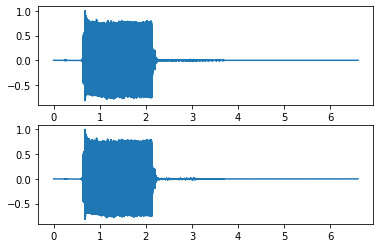

In [7]:
t = np.arange(len(sounds[0][0])) / sounds[0][1]
plt.subplot(211)
plt.plot(t, sounds[0][0])
plt.subplot(212)
plt.plot(t, sounds[0][0])


<p>Nos audios a cima, pode ser claramente visto que que sua forma de onde tem um inicio e o final, POrtante deve ser possivel extrair um periodo desse sinal e expandilo para uma serie de fourier.
<p>É feita a escolha de um periodo dentro do sinal , depois é feita uma busca , periodica dentro do mesmo , encontrando começo e o final do mesmo de forma manual depois é possivel aplicar a expanção.

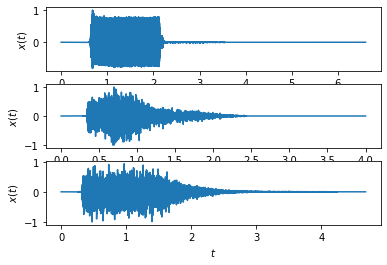

In [8]:
def extractPeriod(data, rate, t_start, t_end):
    t = np.arange(0,len(data))/rate
    plt.plot(t, data)

    duration = t_end - t_start
    plt.xlabel('$t$'); plt.ylabel('$x(t)$');


    sample_start = int(t_start * rate)
    sample_end = int(t_end*rate)

    period = data[sample_start:sample_end]
    audioSideBySide("Original", Audio(data=data,rate=rate), 
                    "Extracted period", Audio(np.tile(period, int(1/duration)), rate=rate))
    return period, rate

periods = []
rates = []
# The manually found start and end time of one period of the signal
periodBounds = [(0.8005,0.8034),
                (0.8044,0.8075),
                (0.20555,0.2132)]
for n, (S, P) in enumerate(zip(sounds, periodBounds)):
    plt.subplot(len(sounds), 1, n+1)
    period, rate = extractPeriod(S[0], S[1], P[0], P[1])
    periods.append(period); rates.append(rate)

<p>Aqui, podemos ouvir os sons originais e a repetição periódica de um período extraído. em alguns casos Pode-se ouvir uma correspondência muito próxima entre os dois sons.pode-se usar um único período da onda para criar um som suave para o instrumento.</p> Além disso, podemos ver explicitamente a periodicidade do sinal observando os gráficos no domínio do tempo. O início e o fim de um período são marcados em cada figura.


<p>MAs para que , a forma de onda dos sons fiquem o mas parecidas possivel, é preciso usar muitos harmonicos, como pode ser visto, no segundo e terceiro caso, a ordem ficou parecida mas o tom criado ficou muito distante do orignal ,do último som apenas tem variações. Podemos esperar que precisamos de muitos harmônicos para gerar com precisão esse sinal.

<p>A baixo uma função que considera um período de um sinal, e calcula a série de Fourier e reconstroi o período até Nth harmônico. Além disso.

In [9]:
def approximateUpToNthHarmonic(period, rate, N):
    t = np.arange(len(period)) / rate
    duration = t.max()
    F = fourierSeries(period, N)
    powers = np.sqrt(np.sum(F**2, axis=1))
    reconstructed = reconstruct(len(period), F)
    
    plt.subplot(121)
    plt.plot(t*1000, period, label='Original') 
    plt.plot(t*1000, reconstructed, label='Reconstructed')
    plt.subplot(122)
    plt.stem(powers)
    
    audioSideBySide("Original", Audio(data=np.tile(period, int(0.7/duration)), rate=rate), 
                    "Reconstructed up to %d harmonics" % N, Audio(data=np.tile(reconstructed, int(0.7/duration)), rate=rate))

<p>aqui se ouvre os sons originais e sua reconstrução com apenas um único harmônico (não consideramos o cosseno de frequência zero um harmônico, pois é apenas um sinal constante)

In [10]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 1)

Reconstrução com apenas dois harmonicos.

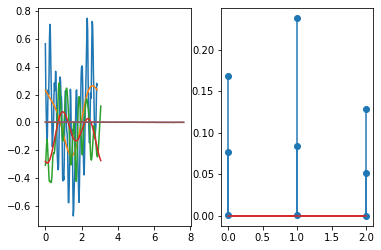

In [11]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 2)

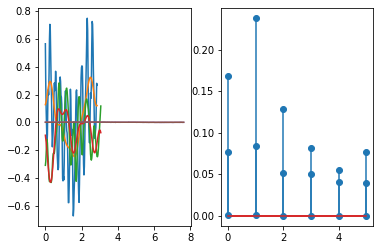

In [12]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 5)

In [13]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 10)

pode se notado com facilidade que quanto mas harmonicos , mas perto do tom original você fica, para o primeiro e segundo som a proximidade é bem maior, ja o terceiro notasse que a complexidade do mesmo, demanda mas harmonicos.

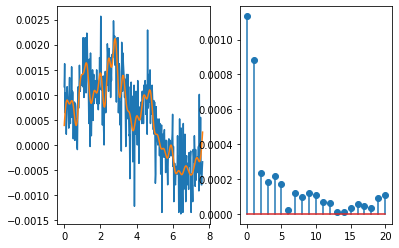

In [14]:
for P, R in list(zip(periods, rates))[2:]:
    approximateUpToNthHarmonic(P, R, 20)

In [15]:
for P, R in list(zip(periods, rates))[2:]:
    approximateUpToNthHarmonic(P, R, 30)
    approximateUpToNthHarmonic(P, R, 40)

Reprodução de uma onda quadrada pela serie fourier.
Reprodução do som de uma onda quadrada.

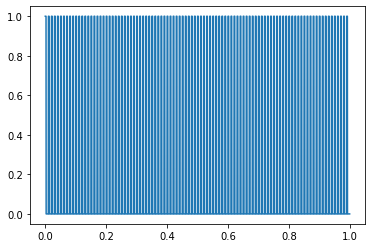

In [16]:
Fs = 10000
F = 100
N = Fs/F
T=1
period = (np.arange(N) < (N/4)).astype(float)
t = np.arange(0, T, 1/Fs)
signal = np.tile(period, T*F)
plt.plot(t, signal)
Audio(data=signal, rate=Fs)

<p>É feita uma analise com a serie fourier de ordens diferentes.

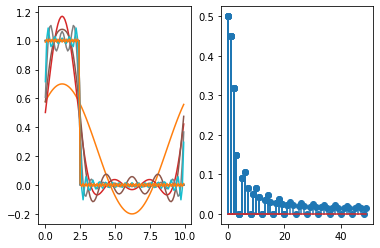

In [17]:
for N in [1, 3, 5, 11, 21, 49]:
    approximateUpToNthHarmonic(period, Fs, N)

<p>Como era esperado, foi preciso de muitos harmônicos para recriar com precisão a forma de onda do sinal. É fato que a transformada de Fourier de um retangular de largura 1/4 é uma função sinc em que os zeros estão separados por 4 unidades. Portanto, novamente é visto uma forte relação entre a série de Fourier e a transformada de Fourier.

<h3>TAREFA 2:</h3><p> Reproduzir os resultados dos 16 exemplos
mostrados no texto em anexo, discutindo se o resultado computacional equivale ao analítico mostrado no
exemplo.


exemplo 8.1

- Sinal Original: $x(t) = e^{-at} \cdot u_1(t),  \quad\quad   a > 0 \\ $ 
- Diagrama de Fase: $∠X(j\omega) = - arctg(\frac{\omega}{a})$
- Diagrama de Módulo: $|X(j\omega)| = \frac{1}{\sqrt{a^{2}+\omega^{2}}} \\ $
- Transformada de Fourier: $X(j\omega) = \frac{1}{(a + j\omega)}, \quad\quad a > 0$

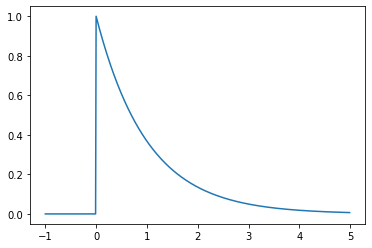

In [18]:
u = lambda t: (t>=0).astype(float)
x = lambda t: np.exp(-a * t)*u(t)

a = 1
t = np.arange(-1,5,0.01)

plt.plot(t, x(t))

<h3>Observações</h3>

<p>Para a aplicação do exercicio, algumas atribuições devem ser feitas, tais como definições de parametros.
Alguns exemplos exigem que certos parametros padrões devem ser diferentes, tais como fase e freguência, que alterna o quao mas particular é sua aplicação, visto principalemnte no uso da onda quadrada, onde foi nescerario impletar funções para atribuir valores univos a "ft".

In [43]:
def ft(samples, Fs, t0):

    f = np.linspace(-Fs/2, Fs/2, len(samples), endpoint=False)
    return np.fft.fftshift(np.fft.fft(samples)/Fs * np.exp(-2j*np.pi*f*t0))

def Fase1(t):
    b = []
    for i in t:
        if(i < -a or i > a):
            b.append(-np.pi)
        else:
            b.append(0)
    return b
def f2(t):  
    a = 1 
    return 1*(np.abs(t) < a)

def f5(t):
    v = []
    for i in t:
        if(-1 <= i <= 0):
            v.append(-1)
        elif(0 < i <= 1):
            v.append(1)
    
    return v

def Fase5(t):
    v = []
    for i in t:
        if(i < 0):
            v.append(-np.pi/2)
        elif(i > 0):
            v.append(np.pi/2)
        else:
            v.append(0)
            
    return v

def f6(t):
    v = []
    for i in t:
        if(np.abs(i) < a):
            v.append(1)
        else:
            v.append(0)
            
    return v

In [44]:
Fs = 10                                    # frequencia usada para simulação
t0 = 5                                       # intervalo
t = np.arange(-t0, t0, 1/Fs)                  # amostras de tempo
af = np.arange(-Fs/2, Fs/2, Fs/len(t))         # amostras de frequencia correspondentes

t_f = ft(x(t), Fs, -t0)

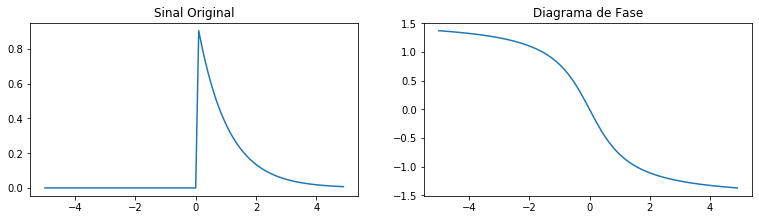

In [45]:
f = lambda t: np.exp(-a*t) * np.heaviside(t, 1)
Fase = lambda w: np.arctan(w/a) * (-1)
Modulo = lambda w: 1 / np.sqrt(a**2 + w**2)
a = 1

plt.figure(figsize=(20, 7))
plt.subplot(231)
plt.title("Sinal Original")
plt.plot(t, f(t))

plt.subplot(232)
plt.title("Diagrama de Fase")
plt.plot(af, Fase(t))

- Diagrama de Fase: $∠X(j\omega) = - arctg(\frac{\omega}{a})$

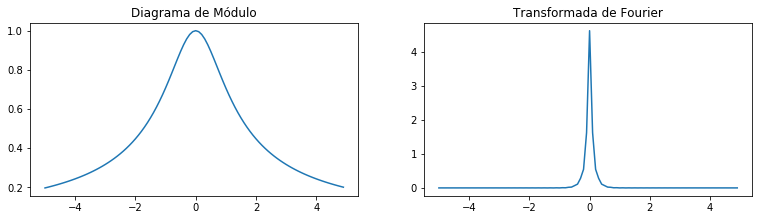

In [46]:
plt.figure(figsize=(20, 7))

plt.subplot(234)
plt.title("Diagrama de Módulo")
plt.plot(af, Modulo(t))

plt.subplot(235)
plt.title("Transformada de Fourier")
plt.plot(af, ft(Modulo(t), Fs, t0).real)

<li>Claramente como pode ser notadao, a monstragem computacional, ficou semelhante ao teorica em todos os sentidos.

<h3>exemplo 8.2</h3>

- Sinal Original: $x(t) = e^{-at} \cdot u_1(t),  \quad\quad   a > 0 \\ $ 

- Diagrama de Fase: $∠X(j\omega) = - arctg(\frac{\omega}{a})$

- Diagrama de Módulo: $|X(j\omega)| = \frac{1}{\sqrt{a^{2}+\omega^{2}}} \\ $

- Transformada de Fourier: $X(j\omega) = \frac{2a}{(a^{2} + \omega^{2})}$

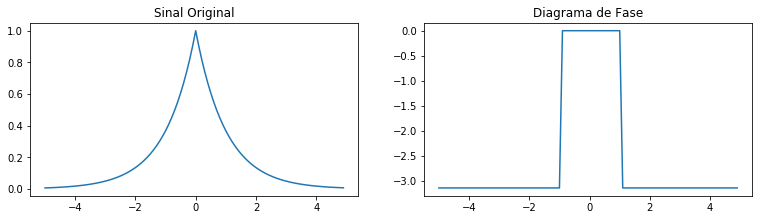

In [47]:
f1 = lambda t: np.exp(-a*np.abs(t))

Modulo1 = lambda w: (2*a) / np.abs((a**2 - w**2))

plt.figure(figsize=(20, 7))

plt.subplot(231)
plt.title("Sinal Original")
plt.plot(t, f1(t))

plt.subplot(232)
plt.title("Diagrama de Fase")
plt.plot(af, Fase1(t))

<li>Dentro do digramada de módulo temos uma diferença, mas o mesmo comportament , ele varia de a a -a .

<h3>exemplo 8.3</h3>

- Sinal Original: $x(t) = \bigg\{ \begin{matrix} 1, \text{se} |t| < a \\ 0, \text{se} |t| > a \end{matrix} \\ $ 

- Diagrama de Fase: $∠X(j\omega) = \bigg\{ \begin{matrix} 0,  \mbox{  se  } X(j\omega)>0 \\ -\pi,  \mbox{ se }X(j\omega) < 0 \end{matrix} \\ $

- Transformada de Fourier: $ \\ X(j\omega) = \frac{2 \text{ sen } (a\omega)}{\omega}$

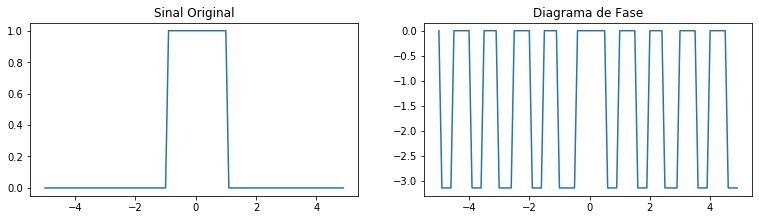

In [24]:
Fase2 = lambda w: -np.pi * ((ft(f2(w), Fs, t0).real) < 0)

plt.figure(figsize=(20, 7))
plt.subplot(231)
plt.title("Sinal Original")
plt.plot(t, f2(t))

plt.subplot(232)
plt.title("Diagrama de Fase")
plt.plot(af, Fase2(t))

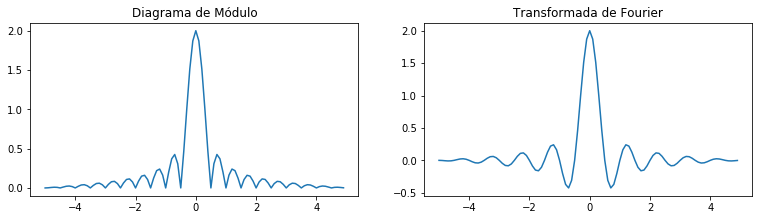

In [25]:
plt.figure(figsize=(20, 7))
plt.subplot(234)
plt.title("Diagrama de Módulo")
plt.plot(af, np.abs(ft(f2(t), Fs, t0).real))

plt.subplot(235)
plt.title("Transformada de Fourier")
plt.plot(af, ft(f2(t), Fs, t0).real)

<li>Obrigatoriedade da inclusão de um novo sinal "f2"para o uso da onda quadrada.

<li>Dentro da transformada, estão sendo assumidos valores, n<=0 e ,n>=0 portanto diferente do teorico , o mesmo comportamento se repeti para o diagrama de fase.

<h3>exemplo 8.4</h3>

- Sinal Original: $ x(t) = sen(\omega_{0}t) \\ $ 

- Transformada de Fourier: $ X(j\omega) = \frac{\pi}{j}\ u_0(\omega - \omega_0) - \frac{\pi}{j}\ u_0 (\omega + \omega_0)$

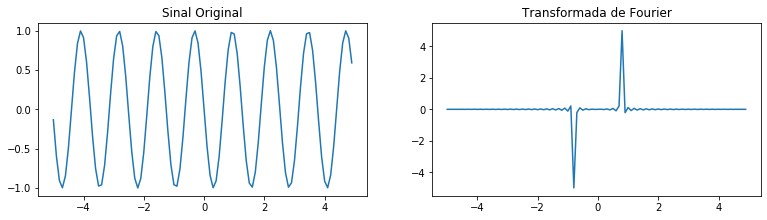

In [26]:
f3 = lambda t: np.sin(w*t)

w = -5

plt.figure(figsize=(20, 7))
plt.subplot(231)
plt.title("Sinal Original")
plt.plot(t, f3(t))

plt.subplot(232)
plt.title("Transformada de Fourier")
plt.plot(af, ft(f3(t), Fs, t0).imag)

<li>Foi obtido o mesmo comportamento 

<h3> exemplo 8.5 </h3>

- Sinal Original: $ x(t) = cos(\omega_{0}t) \\ $ 

- Transformada de Fourier: $  X(j\omega) = \frac{\pi}{j}\ u_0(\omega - \omega_0) - \frac{\pi}{j}\ u_0 (\omega + \omega_0)$



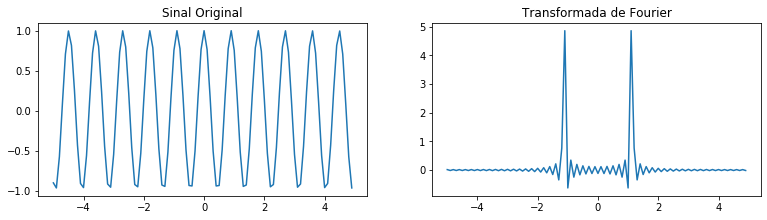

In [27]:
f4 = lambda t: np.cos(w*t)
w = 7

plt.figure(figsize=(20, 7))
plt.subplot(231)
plt.title("Sinal Original")
plt.plot(t, f4(t))

plt.subplot(232)
plt.title("Transformada de Fourier")
plt.plot(af, ft(f4(t), Fs, t0).real)

<li>unica afirmação que posso fazer, é que apenas a parte complexa foi  exibida onde F(w) é uma funçãor par.

<h3>exemplo 8.6 </h3>


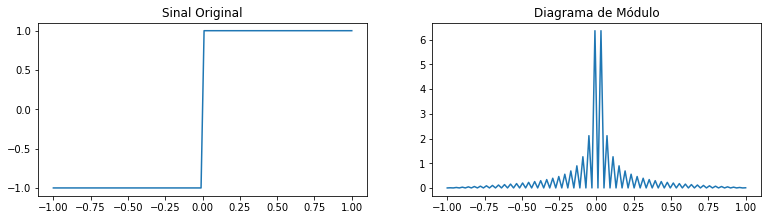

In [28]:
t1 = np.linspace(-1, 1, 100)

plt.figure(figsize=(20, 7))
plt.subplot(231)
plt.title("Sinal Original")
plt.plot(t1, f5(t1))

plt.subplot(232)
plt.title("Diagrama de Módulo")
plt.plot(t1, np.abs(ft(f5(t1), Fs, t0).imag))


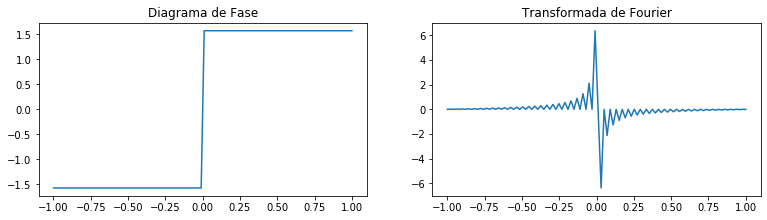

In [29]:
plt.figure(figsize=(20, 7))
plt.subplot(234)
plt.title("Diagrama de Fase")
plt.plot(t1, Fase5(t1))

plt.subplot(235)
plt.title("Transformada de Fourier")
plt.plot(t1, ft(f5(t1), Fs, t0).imag)

<li>Forçada a utilização do pulso quadrado "f5".
<li>De forma geral os resultdos eram oe esperados.

<h3> exemplo 8.7</h3>


- Sinal Original: $x(t) = \bigg\{ \begin{matrix} 1, \ \text{se} |t| < a \\ 0, \ \text{se} \ a<|t|<\frac{T}{2}\end{matrix} \\ $ 


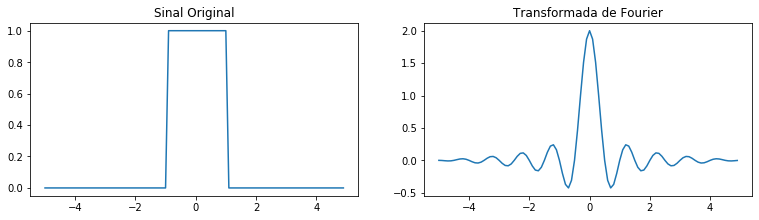

In [30]:
plt.figure(figsize=(20, 7))
plt.subplot(231)
plt.title("Sinal Original")
plt.plot(t, f6(t))

plt.subplot(232)
plt.title("Transformada de Fourier")
plt.plot(af, ft(f6(t), Fs, t0).real)

<li>Forçado a implementação de um novo sinal quadradado "f6",onde o mesmo agora tem maior estenção e é periodico.
<li>Os resultados eram esperados.

<h3>Exemplo 8.8</h3>

- Sinal Original: $x(t) = x_{1}(t - 2,5) + x_{2}(t-2,5) \\ $ 

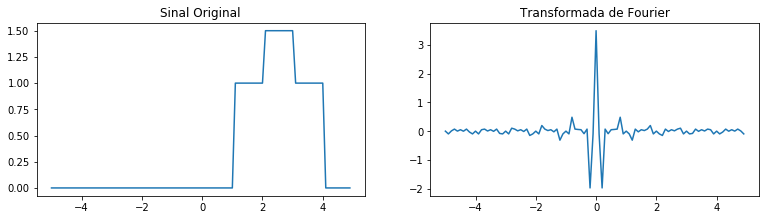

In [31]:
#time shifting
f7 = lambda t: np.heaviside(t-1, 1) + (0.5*np.heaviside(t-2, 1) - 0.5*np.heaviside(t-3, 1)) - np.heaviside(t-4, 1)

plt.figure(figsize=(20, 7))
plt.subplot(231)
plt.title("Sinal Original")
plt.plot(t, f7(t))

plt.subplot(232)
plt.title("Transformada de Fourier")
plt.plot(af, ft(f7(t), Fs, t0).real)

<li>Aplicação de translação no tmepo.
<li>Resultados esperados.

<h3>exemplo 8.9</h3>

- Sinal Original: $x(t) = e^{-a|t|},  \quad\quad   a > 0 \\ $ 

- Transformada de Fourier: $X(j\omega) = \frac{2a}{(a^2 + ω^2)}$


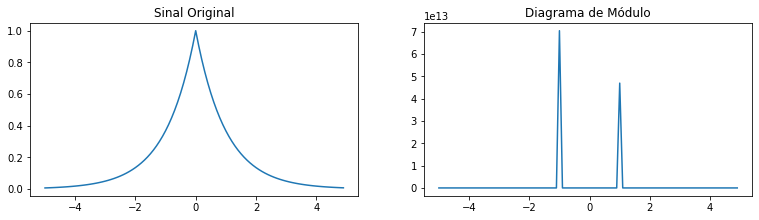

In [32]:
f8 = lambda t: np.exp(-a*np.abs(t)) * (a > 0)
Modulo8 = lambda w: (2*a) / np.abs((a**2 - w**2))

plt.figure(figsize=(20, 7))
plt.subplot(231)
plt.title("Sinal Original")
plt.plot(t, f8(t))

plt.subplot(232)
plt.title("Diagrama de Módulo")
plt.plot(af, Modulo8(t))

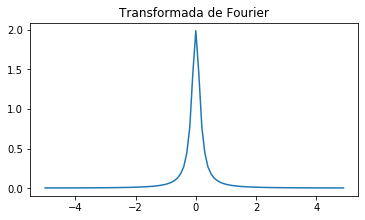

In [33]:
plt.figure(figsize=(20, 7))

plt.subplot(233)
plt.title("Transformada de Fourier")
plt.plot(af, ft(f8(t), Fs, t0).real)

<li>Implementação do exemplo 8.2.
<li>Mesmos resultados.
<li>Resultados espereados.

<h3>exemplo 8.11</h3>

- :$x(t)$

- :$y(t) = {\int_\inf^{t} x(t)dt}$

- :$F{{{\int_\inf^{t} x \tau d \tau = {1 \over jw}F{x(t)} + \pi X(0)u_0(w)}}}$

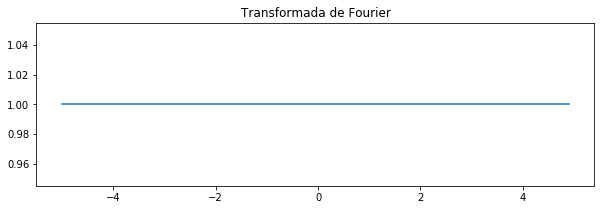

In [34]:
w = 0
j = 0
f9 = lambda t: np.exp(-j*w*t)

plt.figure(figsize=(10, 3))
plt.title("Transformada de Fourier")
plt.plot(t, f9(t))

<h3>exemplo 8.12</h3>

- Sinal Original: $f(t) = e^{-|t|}\\ $ 

- Transformada de Fourier: $F(j\omega) = \frac{2}{(1 + ω^2)}$


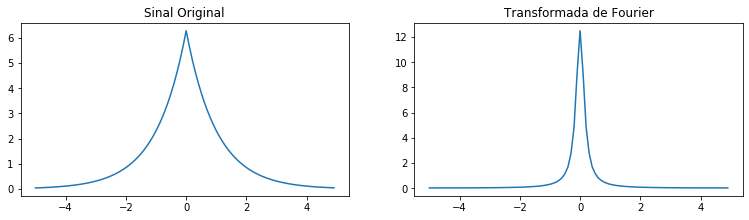

In [35]:
f12 = lambda t: 2*np.pi * np.exp(-np.abs(t))

plt.figure(figsize=(20, 7))
plt.subplot(231)
plt.title("Sinal Original")
plt.plot(t, f12(t))

plt.subplot(232)
plt.title("Transformada de Fourier")
plt.plot(af, ft(f12(t), Fs, t0).real)

<li>Resultados semelhantes ao da 8.2 com a a diferença da aplicação do "Teorema da dualidade"
<li>Inversivel
<li>Resultados esperados.

<h3> exemplo 8.13</h3>

- Transformada de Fourier: $Y(j\omega) = e^{-j \omega t_{0}}\ X(j \omega) \\ $ 

- Time shifiting para a Transformada de Fourier: $y(t) = x(t - t_{0})$

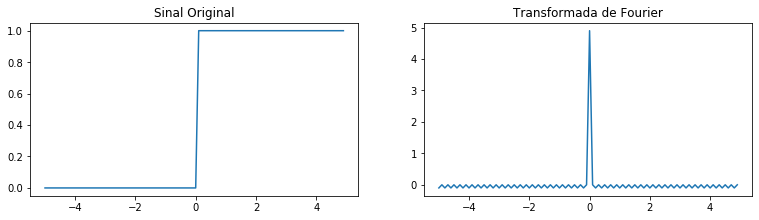

In [36]:
f13 = lambda t: np.heaviside(t - t1, 1)

plt.figure(figsize=(20, 7))
plt.subplot(231)
plt.title("Sinal Original")
plt.plot(t, f13(t))

plt.subplot(232)
plt.title("Transformada de Fourier")
plt.plot(af, ft(f13(t), Fs, t0).real)

<li>Obtenção da resposta dentro do domonio do tempo.
<li>aplicação de time shifting, era esperada um retardo no systema (time delay system)

<h3>exemplo 8.14</h3>

<h6>Exemplo generico</h6>

<p>Considere o sistema SLIT chamado de “diferenciador”, onde para um sinal de
entrada x(t) a saída y(t) é a sua derivada.</p>

- : $y(t) = {dx\over dt}(t)$.

<p>Usando a propriedade da derivada para transformada de Fourier temos que</p>

- : $Y(jw) = jw.X(jw)$.

<p>Logo, pela propriedade da convolução para a transformada de Fourier, a resposta na
frequência H(jω) é H (jω) = jω.</p>

<p> Este resultado é consistente com a definição de : </p>

- :$h(t) = \frac{du_{0}(t)}{dt}$
    

<h3>exemplos 8.16</h3>
    

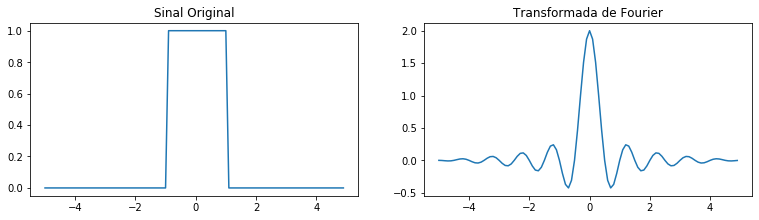

In [37]:
w1 = 1
f16 = lambda w: 1 * np.abs(w) < w1

plt.figure(figsize=(20, 7))
plt.subplot(231)
plt.title("Sinal Original")
plt.plot(t, f16(t))

plt.subplot(232)
plt.title("Transformada de Fourier")
plt.plot(af, ft(f16(t), Fs, t0).real)

 <p>Gráfico de h(t) do filtro passa-baixa ideal (“low pass band filter”). 
 <p>Resultados esperados sem divergencias.